# Make moons

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import einops
import numpy as np

In [2]:
import flax.linen as nn

In [3]:
from sklearn.datasets import make_moons, make_biclusters
from rebayes_mini import callbacks

from rebayes_mini.methods import robust_filter as rf
from rebayes_mini.methods import gauss_filter as gf

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
%config InlineBackend.figure_format = "retina"

In [6]:
key = jax.random.PRNGKey(3141)
key_train, key_corrupt, key_pos, key_val = jax.random.split(key, 4)

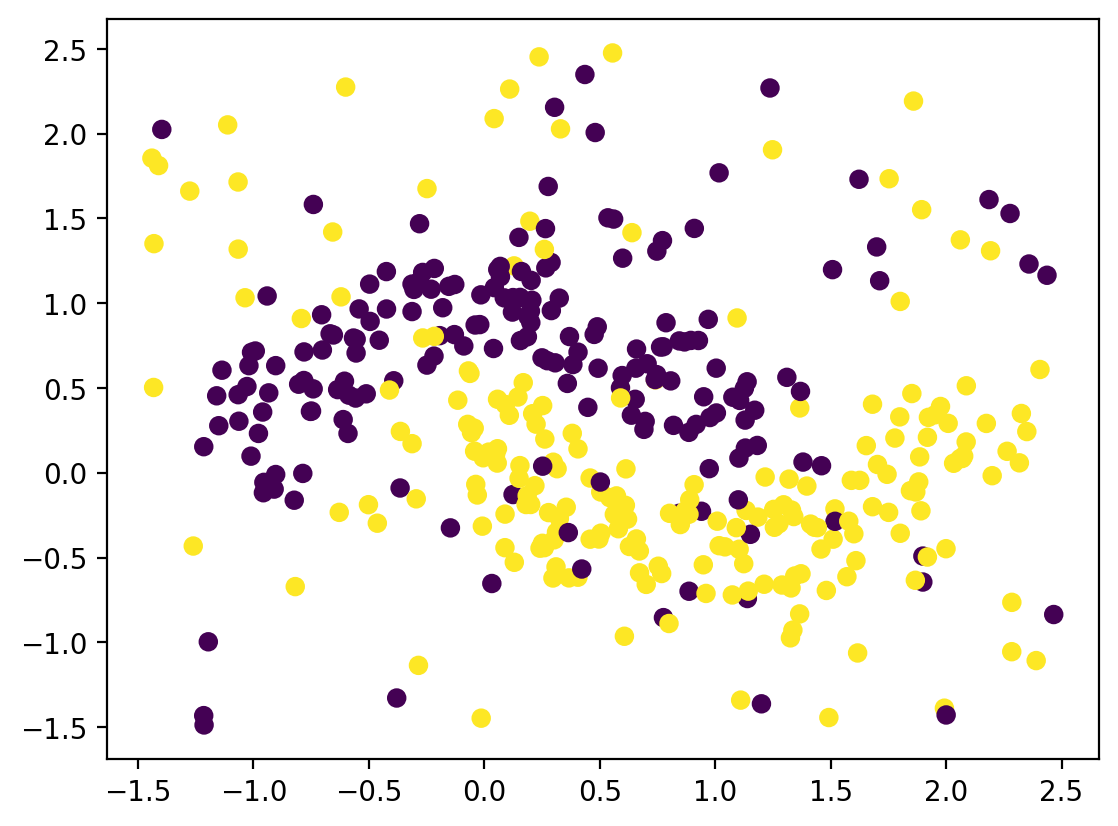

In [657]:
n_samples = 400
n_test = 200

data = make_moons(n_samples=n_samples, noise=0.2, random_state=314)
data_test = make_moons(n_samples=n_test, noise=0.2, random_state=271)
X, y = jax.tree_map(jnp.array, data)
y = y.astype(float)
X_test, y_test = jax.tree_map(jnp.array, data_test)
y_test = y_test.astype(float)


# data = make_biclusters(shape=(n_samples, 2), n_clusters=2, noise=0.5, random_state=314, minval=-2, maxval=2)[:-1]
# data_test = make_biclusters(shape=(n_test, 2), n_clusters=2, noise=0.5, random_state=271, minval=-2, maxval=2)[:-1]
# X, y = jax.tree_map(jnp.array, data)
# X_test, y_test = jax.tree_map(jnp.array, data_test)
# y_test = y_test.astype(float).argmax(axis=0)
# y = y.astype(float).argmax(axis=0)


corrupt_map = jax.random.uniform(key_corrupt, shape=y.shape) < 0.3
corrupt_pos = jax.random.uniform(key_pos, shape=X.shape, minval=-1.5, maxval=2.5)
corrupt_vals = jax.random.bernoulli(key_val, shape=y.shape).astype(int)
corrupt_where = jnp.where(corrupt_map)

X = X.at[corrupt_where].set(corrupt_pos[corrupt_where])
y = y.at[corrupt_where].set(corrupt_vals[corrupt_where])


plt.scatter(*X.T, c=y)

In [658]:
from functools import partial

In [660]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(10)(x)
        x = jnp.sin(x)
        # x = nn.relu(x)
        x = nn.Dense(10)(x)
        x = jnp.sin(x)
        # x = nn.relu(x)

        x = nn.Dense(1)(x)
        return x # Eta
    
model = MLP()
params = model.init(key, X)

# Vanilla filter

In [661]:
def callback(bel, bel_pred, y, x, agent):
    yhat = jax.nn.sigmoid(agent.link_fn(bel_pred.mean, x))
    return yhat

In [662]:
agent = gf.MultinomialFilter(
    model.apply,
    dynamics_covariance=0.0
)

# bel_init = agent.init_bel(params, cov=2.5)
bel_init = agent.init_bel(params, cov=0.5)

cfn = partial(callback, agent=agent)
bel, hist = agent.scan(bel_init, y, X, callback_fn=cfn)

In [663]:
eta = agent.link_fn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5
yhat = yhat.squeeze().astype(float)

In [664]:
(y == yhat.squeeze()).mean()

Array(0.53749996, dtype=float32)

In [665]:
likelihood_vanilla = jnp.log(hist.ravel() ** y * (1 - hist.ravel()) ** (1 - y))

### Test eval

In [666]:
eta_test = agent.link_fn(bel.mean, X_test)
probs_test_vanilla = jax.nn.sigmoid(eta_test)
yhat_test = (probs_test_vanilla  > 0.5).squeeze().astype(float)

In [667]:
(y_test == yhat_test.squeeze()).mean()

Array(0.60499996, dtype=float32)

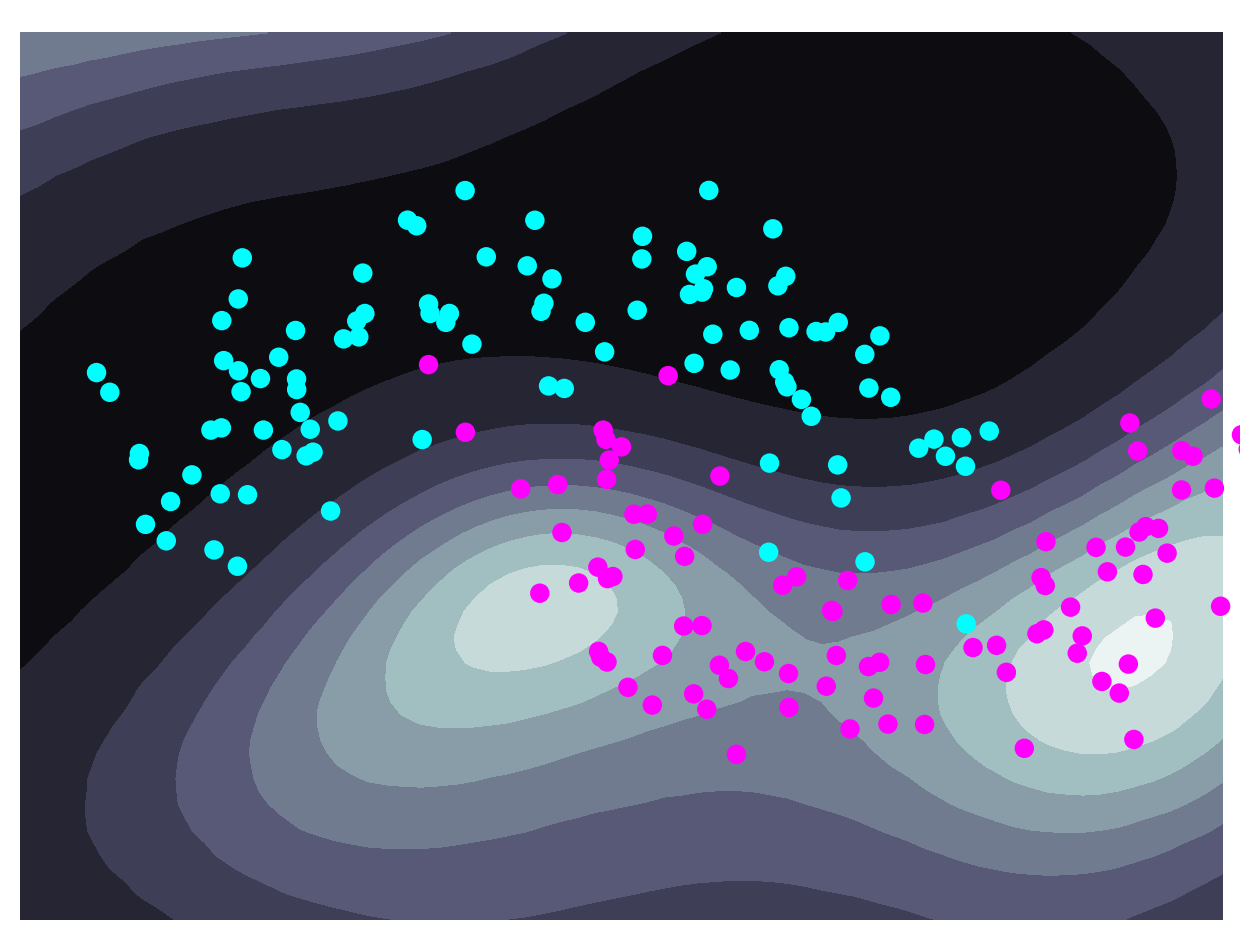

In [669]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
# plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
# plt.contour(*XX, mean_Z, cmap="bone")
plt.scatter(*np.array(X_test).T, c=y_test, cmap="cool")
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

# Robust filter

In [670]:
agent = rf.RobustBernoulliFilter(
    model.apply,
    dynamics_covariance=0.0,
    c=1.0
)

# bel_init = agent.init_bel(params, cov=2.5)
bel_init = agent.init_bel(params, cov=0.5)

cfn = partial(callback, agent=agent)
bel, hist = agent.scan(bel_init, y, X, callback_fn=cfn)

In [671]:
likelihood_robust = jnp.log(hist.ravel() ** y * (1 - hist.ravel()) ** (1 - y))

In [672]:
eta = agent.link_fn(bel.mean, X)
yhat = jax.nn.sigmoid(eta) > 0.5
yhat = yhat.squeeze().astype(float)

In [673]:
(y == yhat.squeeze()).mean()

Array(0.8225, dtype=float32)

### Test eval

In [674]:
eta_test = agent.link_fn(bel.mean, X_test)
probs_test_robust = jax.nn.sigmoid(eta_test) #> 0.5
yhat_test = (probs_test_robust > 0.5).squeeze().astype(float)

In [675]:
(y_test == yhat_test.squeeze()).mean()

Array(0.95, dtype=float32)

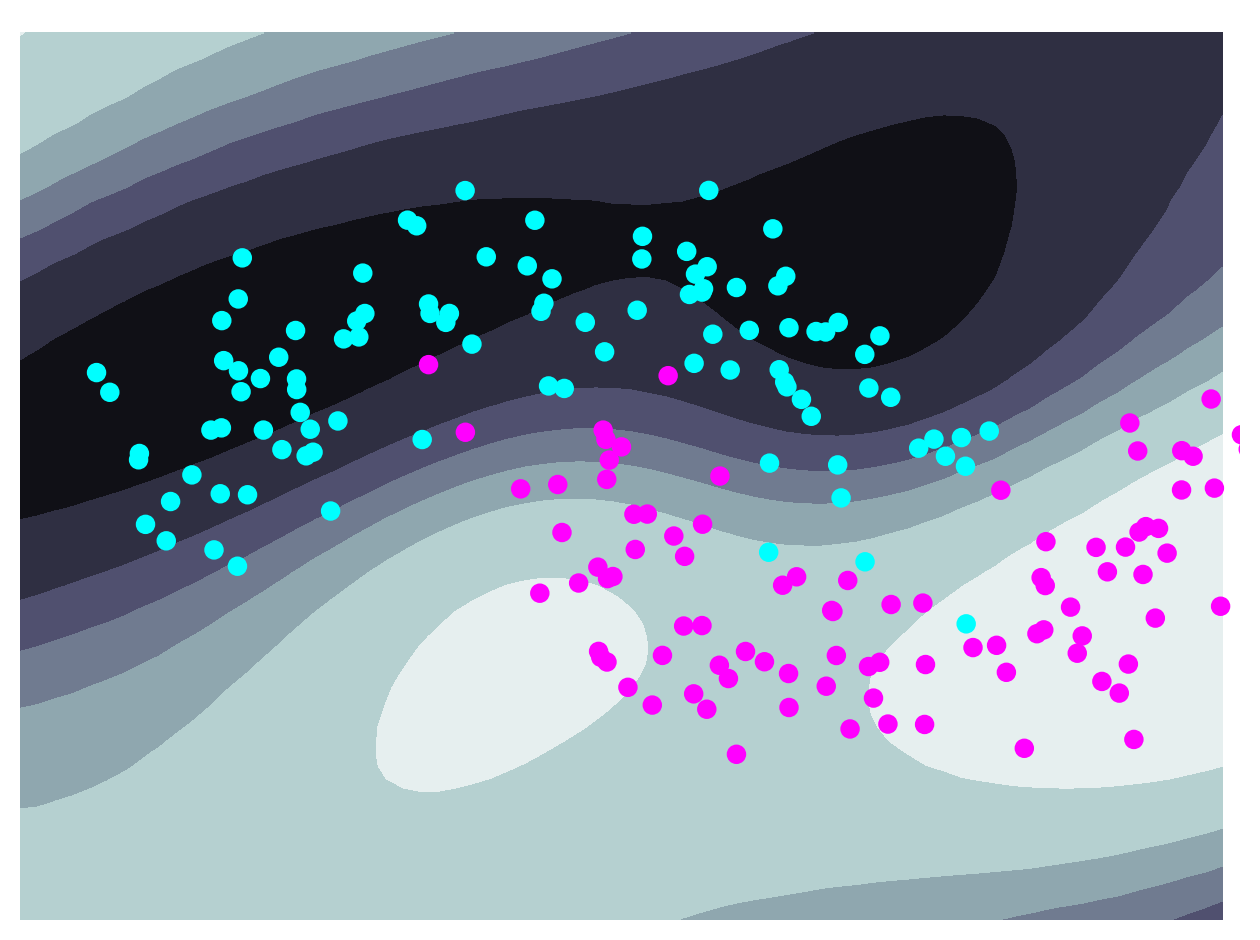

In [676]:
XX = np.mgrid[-1.5:2:0.05, -1.5:2:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

plt.contourf(*XX, mean_Z, cmap="bone")
# plt.contour(*XX, mean_Z > 0.5, colors="black", linestyles="--")
plt.scatter(*np.array(X_test).T, c=y_test, cmap="cool")

plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()

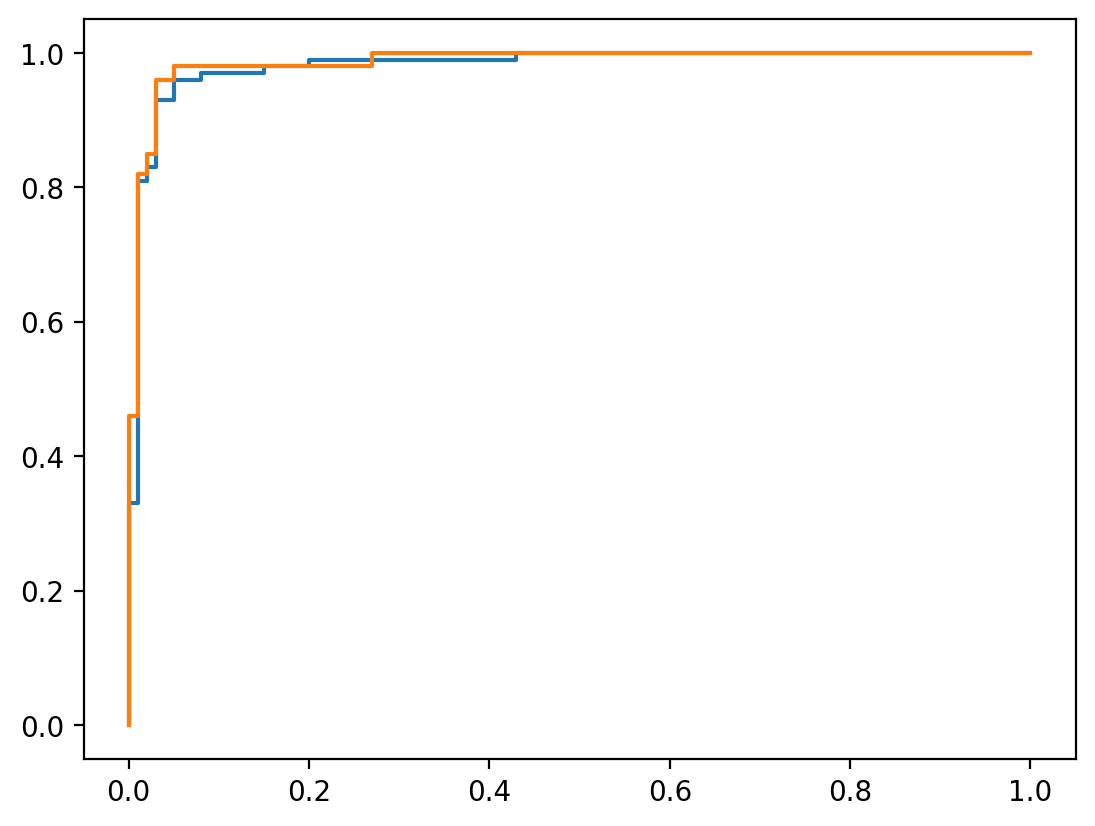

In [677]:
from sklearn.metrics import roc_curve, roc_auc_score
plt.plot(*roc_curve(y_test, probs_test_robust)[:-1])
plt.plot(*roc_curve(y_test, probs_test_vanilla)[:-1])

In [678]:
roc_auc_score(y_test, probs_test_vanilla)

0.9861

In [679]:
roc_auc_score(y_test, probs_test_robust)

0.9817

In [292]:
import pandas as pd
pd.DataFrame({
    "robust": likelihood_robust,
    "vanilla": likelihood_vanilla
}).expanding().sum().plot()

NameError: name 'likelihood_robust' is not defined

# Multinomial

In [296]:
n_test = 200
n_obs = 400 + n_test
k = 3# TODO: remove hard-code
X, y, _ = make_biclusters(
    (n_obs, 2), k, noise=10, random_state=31, shuffle=True,
    minval=-100, maxval=100
)
X = (X - X.mean(axis=0, keepdims=True)) / X.std(axis=0, keepdims=True)

y = y.T

X = jnp.array(X)
y = jnp.array(y).astype(float)


X_test = X[-n_test:]
y_test = y[-n_test:]

X = X[:-n_test]
y = y[:-n_test]

In [311]:
corrupt_map = jax.random.uniform(key_corrupt, shape=y.shape) < 0.1
corrupt_pos = jax.random.uniform(key_pos, shape=X.shape, minval=-2.5, maxval=2.5)
corrupt_vals = jax.random.choice(key_val, k + 1, shape=y.shape[:1]).astype(int)
corrupt_where = jnp.where(corrupt_map)

corrupt_vals = jax.nn.one_hot(corrupt_vals, k)
X = X.at[corrupt_where].set(corrupt_pos[corrupt_where])
y = y.at[corrupt_where].set(corrupt_vals[corrupt_where])

In [312]:
ycat = y.argmax(axis=1).astype(float)

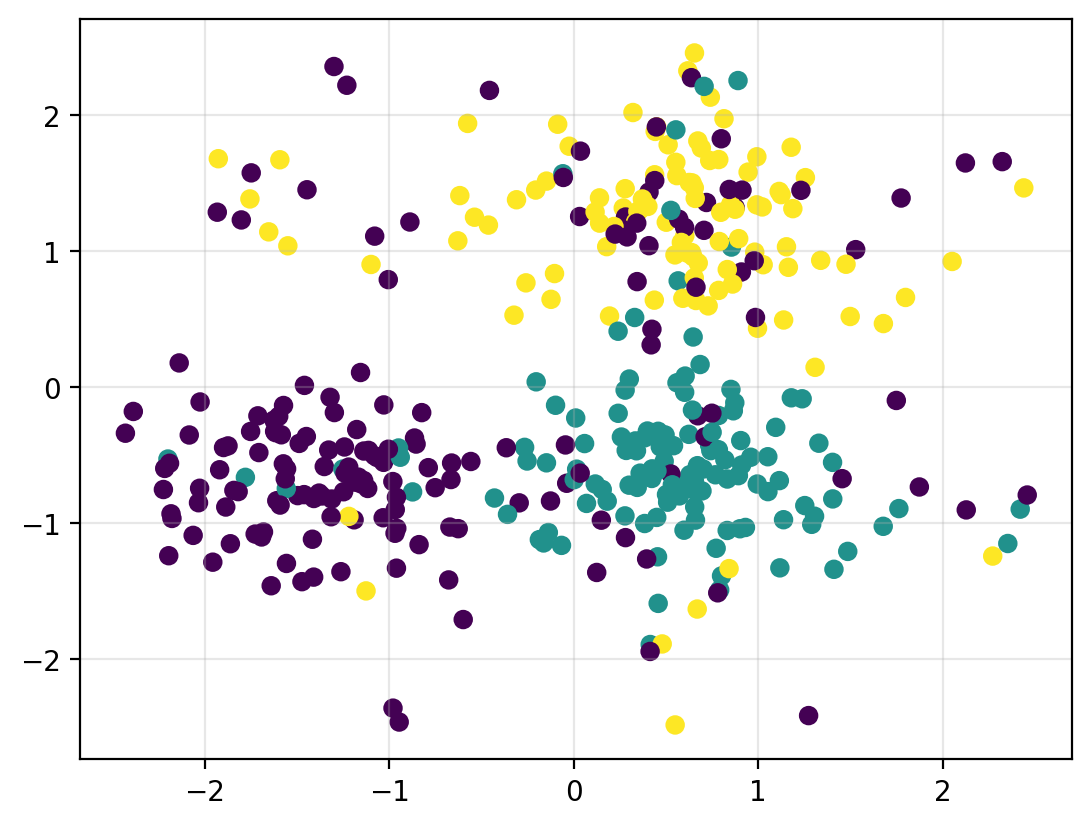

In [313]:
plt.scatter(*X.T, c=y.argmax(axis=1))
plt.grid(alpha=0.3)

In [314]:
class MLP(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(50)(x)
        x = jnp.sin(x)
        x = nn.Dense(50)(x)
        x = nn.relu(x)
        
        eta = nn.Dense(k)(x)
        return eta
    
model = MLP()
params = model.init(key, X)

In [315]:
X.shape

(400, 2)

In [316]:
agent = gf.MultinomialFilter(
    model.apply,
    dynamics_covariance=0.0,
)


agent = rf.RobustMultinomialFilter(
    model.apply,
    dynamics_covariance=0.0,
    c=5.0
)


bel_init = agent.init_bel(params, cov=1e-3)
bel, bel_hist = agent.scan(bel_init, y, X)
# Link function
eta = agent.link_fn(bel_init.mean, X[0])

In [317]:
etas = agent.link_fn(bel.mean, X)
yhat = jax.vmap(agent.mean)(etas)
yhat_cat = yhat.argmax(axis=1)
(yhat_cat == ycat).mean();

In [318]:
etas = agent.link_fn(bel.mean, X_test)
yhat = jax.vmap(agent.mean)(etas)
yhat_cat = yhat.argmax(axis=1)

In [319]:
confusion_matrix(y_test.argmax(axis=1), yhat_cat)

array([[57,  5,  0],
       [ 1, 59,  4],
       [ 0,  0, 74]])

In [320]:
(y_test.argmax(axis=1) ==  yhat_cat).mean()

Array(0.95, dtype=float32)

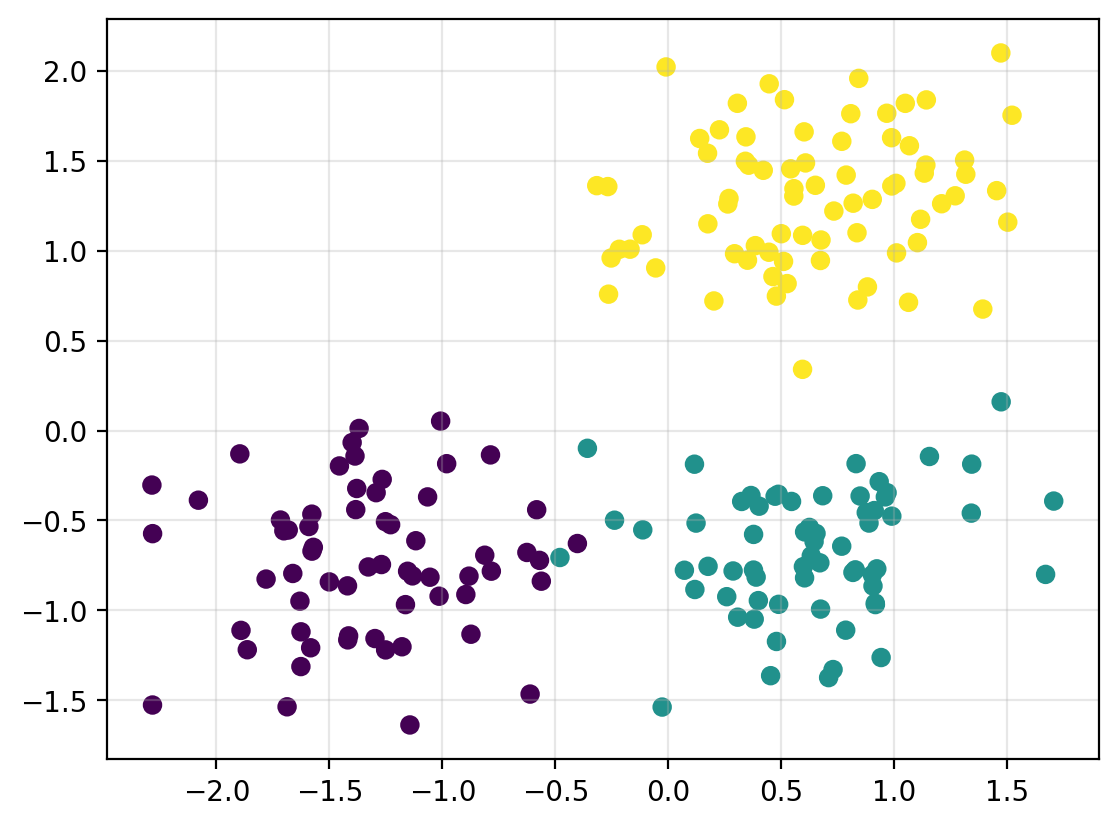

In [321]:
plt.scatter(*X_test.T, c=y_test.argmax(axis=1))
plt.grid(alpha=0.3)

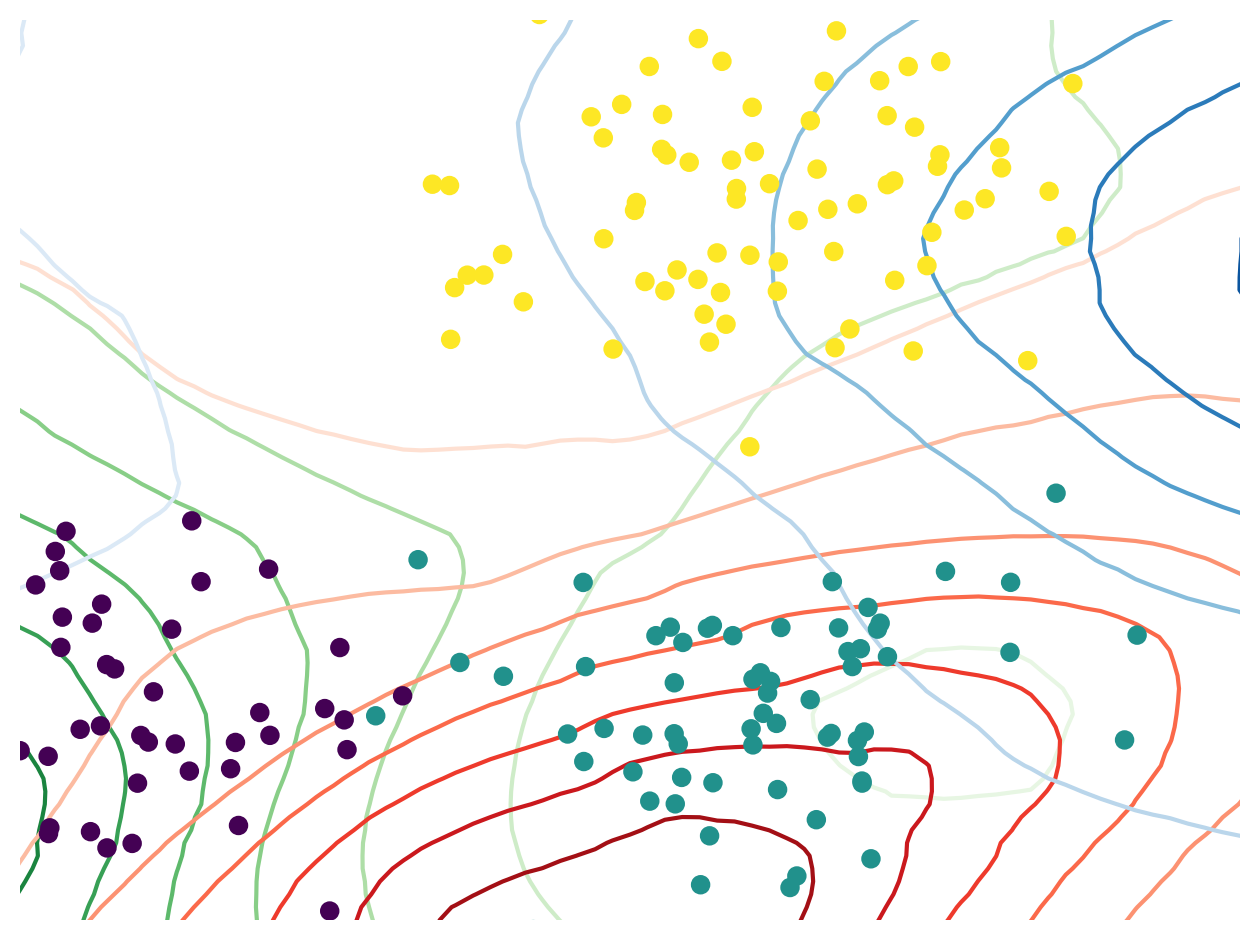

In [322]:
XX = np.mgrid[-2.5:2.5:0.05, -2.5:2.5:0.05]

Xeval = einops.rearrange(XX, "d x y -> x y d")

Z = agent.link_fn(bel.mean, Xeval).squeeze()
mean_Z = agent.mean(Z)

# plt.contourf(*XX, Z.mean(axis=-1), cmap="cividis")
plt.contour(*XX, mean_Z[..., 0], cmap="Greens")
plt.contour(*XX, mean_Z[..., 1], cmap="Reds")
plt.contour(*XX, mean_Z[..., 2], cmap="Blues")

plt.scatter(*np.array(X_test).T, c=y_test.argmax(axis=1), zorder=2)
plt.ylim(-1.5, 2)
plt.xlim(-1.5, 2)
plt.axis("off")
plt.tight_layout()